## Mineral Predicting App
### App that predicts mineral composition from fluorescing images. User can import speficic training data set, and chose which values to use for prediction (hue, hssv, rgb, etc). Testing image can be enhanced to exclude bad pixels and background. App outputs spatial prediction and mineral prediction pixel count.

#### Once training library is selected, and values for prediction, app displays those library values for your examination. Then selected images from testing folder can be manipulated (saturation control with slide bar, deleting specific pixel areas with cursur, and blurring to exclude bad pixels). With deleting pixels, double click for single selection, click and drag for large area. 

In [1]:
import PIL
import tkinter
import cv2
from tkinter import *
from PIL import Image, ImageGrab, ImageDraw
from PIL import ImageTk
from tkinter import filedialog
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler 
from skimage import img_as_ubyte, img_as_uint, img_as_float64, transform
from skimage.transform import rescale, resize
from matplotlib.figure import Figure
from sklearn import preprocessing
from skimage.color import (rgb2hsv,rgb2lab,rgb2rgbcie)
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%config InlineBackend.figure_format = 'retina' 
from skimage import io  
import customtkinter
from CTkRangeSlider.ctk_rangeslider import CTkRangeSlider
from CTkRangeSlider import *
import os
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg, 
NavigationToolbar2Tk)
import colorcet as cc
pwd = os.getcwd()

In [113]:
def select_lib():
    global df, classifier_neighbors, tag
    path = filedialog.askopenfilename(initialdir= f'{pwd}\\Libraries\\')
    df =  pd.read_csv(path)
    pick_test_value()
    
def pick_test_value():
    global df, test_value,kval_var
    test_value = []
    test_list = df.columns.to_list()
    test_list.remove('Mineral')
    listbox = Listbox(tool_frame, width=16, height=4, selectmode=MULTIPLE)
    listbox.grid(row=2, column=0, rowspan=3, columnspan = 2,padx=1, pady=1)
    
    kval_var = StringVar()
    Label(tool_frame,text="K Values:").grid(row=5, column=0)
    kval_entry =  Entry(tool_frame,textvariable=kval_var,width =10)
    kval_entry.grid(row=5, column=1)
    
    for i in range(0,len(test_list)):
        listbox.insert(i,test_list[i])
    def values_selected():
        for i in listbox.curselection():
            test_value.append(listbox.get(i))
        load_lib()
    load = Button(tool_frame, text='Load Selected', command= values_selected)
    load.grid(row=6, column=0, columnspan = 2, padx=5, pady=1)
    
def load_lib():
    global df, classifier_neighbors, tag, scaler, test_value, score, kval_var
    data = df.copy()
    tag = preprocessing.LabelEncoder()
    tag.fit(data['Mineral'])
    data['Mineral'] = tag.transform(data['Mineral'])
    print(test_value)
    kval = [int(x) for x in kval_var.get().split(" ")]
    print(kval)
    value = data[test_value]
    mineral = data['Mineral']
    value_train, value_test, mineral_train, mineral_test = train_test_split(value,mineral,test_size=0.3, random_state=5)
    scaler=StandardScaler()
    value_train_scaled=scaler.fit_transform(value_train)
    value_test_scaled=scaler.fit_transform(value_test)
    
    from warnings import simplefilter
    simplefilter(action='ignore', category=FutureWarning)
    
    res=[]
    sres = []
    for i in kval:
        clf = KNeighborsClassifier(n_neighbors=i)
        n = cross_validate(clf, value_train, mineral_train, cv=5, scoring='accuracy')
        ns = cross_validate(clf, value_train_scaled, mineral_train, cv=5, scoring='accuracy')
        res.append(n['test_score'].mean())
        sres.append(ns['test_score'].mean())
    if max(res) >= max(sres):
        value_all = value
        train = value_train
        test = value_test
        acc = max(res)*100
        if len(kval)>1:
            k = kval[np.argmax(res)]
    if max(res) < max(sres):
        value_all = scaler.fit_transform(value)
        train = value_train_scaled
        test = value_test_scaled
        acc =max(sres)*100
        if len(kval)>1:
            k = kval[np.argmax(sres)]
    if len(kval)==1:
        k = kval[0]
        
    print(f'Best K: {k}, score = {acc}')
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train, mineral_train)
    prediction = clf.predict(test)
    f = classification_report(tag.inverse_transform(mineral_test), tag.inverse_transform(prediction),output_dict=True)
    labf = pd.DataFrame(f).transpose()
    labf['total accuracy'] =  labf.loc[['accuracy']].values[0,0]
    labf = labf.drop(['accuracy','macro avg','weighted avg'])
    labf.reset_index(inplace=True)
    labf = labf.rename(columns = {'index':'Mineral'})
    score = labf                 
    
    classifier_neighbors = KNeighborsClassifier(n_neighbors=k)
    classifier_neighbors.fit(value_all, mineral)
    disp_lib()
    
def disp_lib():
    global df, test_value
    width= class_frame.winfo_width()
    height= class_frame.winfo_height()
    
    palette = sns.color_palette(cc.glasbey, n_colors=len(df['Mineral'].unique()))
    sns.set_theme(style = "ticks", palette=palette)
    sns.set_context("notebook", font_scale = 0.65)
    
    if len(test_value) == 1:
        v=0
        x = str(test_value[int(v)])
        fig, ax = plt.subplots(figsize=(width/100,height/100), dpi=100)
        ax.set_title(f'Category Selected from Mineral Library')
        sns.histplot(data=df, x=x, hue = 'Mineral', kde=True, fill=False, stat="percent", ax=ax,
                 element="step",legend= False,hue_order= df['Mineral'].unique())
        ax.set_xlim(0,max(df[x]))
        ax.set_xlabel(x)
    if (len(test_value) <= 3) & (len(test_value) > 1):
        rows=len(test_value)
        fig, ax = plt.subplots(figsize=(width/100,height/100), dpi=100,nrows=rows, ncols=1,constrained_layout = True)
        v=0
        for i in range(0,rows):
            x = str(test_value[int(v)])
            ax[0].set_title(f'Category Selected from Mineral Library')
            sns.histplot(data=df, x=x, hue = 'Mineral', kde=True, fill=False, stat="percent", ax=ax[i],
                     element="step",legend= False,hue_order= df['Mineral'].unique())
            ax[i].set_xlim(0,max(df[x]))
            ax[i].set_xlabel(x)
            v = v+1
    if len(test_value) > 3:
        n=len(test_value)
        rows= 3 - 1*(n==4)
        cols = int(np.ceil(n/rows))
        fig, ax = plt.subplots(figsize=(width/100,height/100), dpi=100,nrows=rows, ncols=cols,constrained_layout = True)
        v=0
        for i in range(0,rows):
            for j in range(0,cols):
                if v < len(test_value):
                    x = str(test_value[int(v)])
                    fig.suptitle('Category Selected from Mineral Library')
                    sns.histplot(data=df, x=x, hue = 'Mineral', kde=True, fill=False, stat="density", ax=ax[i,j],
                             element="step",legend=False,hue_order= df['Mineral'].unique())
                    ax[i,j].set_xlabel(x)
                    v = v+1
                if v > len(test_value):
                    ax[i,j].set_xticklabels([])
                    ax[i,j].set_yticklabels([])
                    ax[i,j].set_axis_off()
                
    f = FigureCanvasTkAgg(fig, master = class_frame)
    f.get_tk_widget().grid(sticky=NS)
    f.draw()
    
    sns.set_context("notebook", font_scale = 0.65)
    sns.set_theme(style = "ticks", palette=palette)
    
    width= lib_frame.winfo_width()
    height= lib_frame.winfo_height()
    fig0 = Figure(figsize=(width/100,height/100), dpi=100)
    ax0 = fig0.add_subplot()
    
    sns.histplot(data=df, y='Mineral', hue = 'Mineral', stat="percent", ax= ax0, 
                 legend=False,hue_order= df['Mineral'].unique())
    ax0.set_title('Mineral Pixel Count in Library')
    ax0.set(ylabel=None)
    
    f0 = FigureCanvasTkAgg(fig0, master = lib_frame)
    f0.get_tk_widget().grid(sticky=NS)
    f0.draw()
    
    

In [98]:
def go():
    global im_filtered,classifier_neighbors, tag, df,scaler,test_value
    for widget in class_frame.winfo_children():
            widget.destroy()
    read_rgb()
    
def read_rgb():
    global im_filtered,classifier_neighbors, tag, df, scaler,test_value, sample
    width= root.winfo_width()/2
    height= root.winfo_height()*2/3
    img = size(im_filtered,width,height)
    img = img_as_float64(img)
    array_img = np.asarray(img)
    hsv_img = rgb2hsv(img)
    lab_img = rgb2lab(img)
    rgbcie_img = rgb2rgbcie(img)
    rgb_img = img
    
    image = hsv_img
    pixels = np.asarray(image).max()
    h = image[:,:,0]/np.max(pixels)
    s = image[:,:,1]/np.max(pixels)
    v = image[:,:,2]/np.max(pixels)
    good = v>0.1
    hue = h[good].ravel()
    sat = s[good].ravel()
    val = v[good].ravel()

    image = lab_img
    pixels = np.asarray(np.abs(image)).max()
    l = image[:,:,0]/np.max(pixels)
    a = image[:,:,1]/np.max(pixels)
    b = image[:,:,2]/np.max(pixels)
    L = l[good].ravel()
    A = a[good].ravel()
    B = b[good].ravel()

    image = rgbcie_img
    pixels = np.asarray(image).max()
    s = image[:,:,0]/np.max(pixels)
    m = image[:,:,1]/np.max(pixels)
    l = image[:,:,2]/np.max(pixels)
    short = s[good].ravel()
    med = m[good].ravel()
    lon = l[good].ravel()

    image = rgb_img
    pixels = np.asarray(image).max()
    red = image[:,:,0]/np.max(pixels)
    green = image[:,:,1]/np.max(pixels)
    blue = image[:,:,2]/np.max(pixels)
    r = red[good].ravel()
    g = green[good].ravel()
    b = blue[good].ravel()
    
    x,y,z = array_img.shape
    long = x*y
    linear = np.linspace(0,long-1, long, dtype = int)
    lin_good = good.ravel()
    lin = linear[lin_good]
    arr = np.unravel_index(lin, [x,y])
    arr_x = arr[0]
    arr_y = arr[1]
    
    sample = pd.DataFrame({'r': r, 'g': g, 'b': b, 
                        'short': short, 'med': med, 'lon': lon,
                        'L': L, 'A': A, 'B': B,
                        'hue': hue, 'saturation': sat, 'value': val})
    
    identify_mineral()
    
    dt=sample.copy()
    
    dt['x'] = arr_x
    dt['y']= arr_y
    
    for widget in class_frame.winfo_children():
        widget.destroy()
        
    palette = sns.color_palette(cc.glasbey, n_colors=len(sample['Pixel Mineral Prediction'].unique()))
    sns.set_theme(style = "ticks", palette=palette)
    sns.set_context("notebook", font_scale = 0.65)
    
    fig = Figure(figsize=(y/200,x/200), dpi=200)
    ax = fig.add_subplot()
    
    alphas = dt['Confidence Score'].sort_values().unique()
    for alpha in alphas:
        sns.scatterplot(data=dt[dt['Confidence Score'] == alpha], x='y', y = 'x', hue = 'Pixel Mineral Prediction', 
                    s = 1.5,alpha = alpha, marker ='s',ax= ax, legend=False,
                    hue_order=dt['Pixel Mineral Prediction'].unique(),edgecolor = 'none')
      
    ax.set(xlabel=None,ylabel=None,xticklabels=[],yticklabels=[])
    ax.tick_params(bottom=False,left=False) 
    ax.set_xlim(0,y)
    ax.set_ylim(x,0)
    ax.axis("off")
    f = FigureCanvasTkAgg(fig, master = class_frame)
    f.get_tk_widget().grid(sticky=NS)
    f.draw()
    
    for widget in lib_frame.winfo_children():
        widget.destroy()
        
    palette = sns.color_palette(cc.glasbey, n_colors=len(sample['Pixel Mineral Prediction'].unique()))
    sns.set_theme(style = "ticks", palette=palette)
    sns.set_context("notebook", font_scale = 0.65)
    
    ww= lib_frame.winfo_width()
    hh= lib_frame.winfo_height()
    fig0 = Figure(figsize=(ww/100,hh/100), dpi=100)
    ax0 = fig0.add_subplot()
    
    sns.histplot(data=dt, y='Pixel Mineral Prediction', hue = 'Pixel Mineral Prediction', stat="proportion", ax= ax0, 
                 legend=False,hue_order= dt['Pixel Mineral Prediction'].unique(),palette=palette)
    ax0.set(ylabel=None)
    f0 = FigureCanvasTkAgg(fig0, master = lib_frame)
    f0.get_tk_widget().grid(sticky=NS)
    f0.draw()

def identify_mineral():
    global classifier_neighbors, tag, scaler, test_value, score, sample
    test = sample[test_value].values
    prediction = classifier_neighbors.predict(test)
    sample['Pixel Mineral Prediction'] = tag.inverse_transform(prediction)
    dit = score[['Mineral','f1-score']].set_index('Mineral').to_dict()['f1-score']
    def set_value(row_number, assigned_value):
        return assigned_value[row_number]
    
    s = sample['Pixel Mineral Prediction'].apply(set_value, args=(dit,))
    sample['Confidence Score'] = np.round_(s.values, decimals = 1)
   

In [99]:
def select_file():
    global df, fltr, blur, folder, counter, pixel_x, pixel_y, x, y,w,h
    folder = filedialog.askdirectory(initialdir= f'{pwd}\\Catalog\\')
    w= im_frame.winfo_width()
    h= im_frame.winfo_height()
    file_imgs()
    
def file_imgs():
    global folder, list_images, counter, max_count, fltr, blur, pixel_x, pixel_y, x, y
    list_images = []
    for file in os.listdir(folder):
         if file.endswith('png') or file.endswith('jpg'):
            list_images.append(file)
    max_count = len(list_images)-1
    disp_img()
    
def disp_img():
    global folder, list_images, im, w, h,counter, fltr, blur, canvas, pixel_x, pixel_y, x, y,img_name
    im_path = f'{folder}\\{list_images[counter]}'
    im = io.imread(im_path)
    img_name =Label(tags_frame,text='Image Name:' + str(list_images[counter]) )
    img_name.grid(row=3, column = 0)
    canvas = Canvas(im_frame, width=w, height=h, borderwidth=0)
    canvas.grid(row=0, column=0)
    update_image()
        
def update_image():
    global im, w, h, fltr, blur, pixel_x, pixel_y, x, y, adapted_im, im_filtered, canvas
    im_filtered = filter_pixel(im,w,h,fltr,blur,pixel_x, pixel_y) 
    adapted_im = ImageTk.PhotoImage(Image.fromarray(img_as_ubyte(im_filtered)))
    #canvas.config(width=w, height=h)
    canvas.create_image(0, 0, image=adapted_im, anchor=NW)

def change_filter(var):
    global im, fltr, blur, pixel_x, pixel_y, x, y
    fltr = var
    fltr_values = Label(tool_frame, text = f"Saturation Filter: {min(fltr): .2f} - {max(fltr): .2f}")
    fltr_values.grid(row=1, column=2)
    update_image()

def change_blur():
    global im, fltr, blur, pixel_x, pixel_y, x, y
    blur = blur_slider.get()
    update_image()

def select_pixels():  
    global im, fltr, blur,  adapted_im,pixel_x, pixel_y, x, y, canvas
    canvas.bind("<B1-Motion>", save_cord)
    canvas.bind("<Double-Button-1>", save_cord)
    #canvas.bind("<Control-z>", lambda e: del_pixel())
    
def del_pixel():
    global im, fltr,blur, pixel_x, pixel_y
    mid = len(pixel_x)/2
    pixel_x= pixel_x[mid:-1]
    pixel_y = pixel_y[mid:-1]
    update_image()
    
def save_cord(event):
    global im, fltr, blur, pixel_x, pixel_y, x, y
    x = int(event.x)
    y = int(event.y)
    pixel_x.append(x)
    pixel_y.append(y)
    update_image()

def next_img():
    global list_images, im, counter, counter_max,fltr, blur, pixel_x, pixel_y, x, y
    counter += 1
    if counter > max_count:
        max_root = Toplevel(root)
        max_root.title("End of File")
        max_frame = Frame(max_root, width=300, height=300)
        max_frame.pack(side = TOP, expand=True, fill="both")
        Label(max_frame,text="You Reached End of Folder").grid(row=0, column=0, padx=5, pady=5)
        #Button(max_frame, text="Save this Library",command=save_lib).grid(row=1, column=2, padx=5, pady=5)
    else:
        fltr = [0,100]
        blur= 0
        x = IntVar
        y = IntVar
        pixel_x = []
        pixel_y = []
        fltr_slider.set(fltr)
        fltr_values=Label(tool_frame, text = f"Saturation Filter:{min(fltr): .2f} - {max(fltr): .2f}")
        fltr_values.grid(row=1, column=2)
        blur_slider.set(blur)
        for widget in class_frame.winfo_children():
            widget.destroy()
        for widget in lib_frame.winfo_children():
            widget.destroy()
        disp_img()


def undo_img():
    global im, fltr, blur, pixel_x, pixel_y, x, y, adapted_im, im_filtered, canvas, counter
    counter -= 1
    fltr = [0,100]
    blur= 0
    pixel_x = []
    pixel_y = []
    x = IntVar
    y = IntVar
    fltr_slider.set(fltr)
    fltr_values.config(text = f"Sauration Filter: {min(fltr): .2f} - {max(fltr): .2f}")
    fltr_values.grid(row=1, column=2)
    blur_slider.set(blur)
    update_image()
    
    
def save():
    global prediction_fig
    save_root = Toplevel(root)
    save_root.title("End of File")
    save_frame = Frame(save_root, width=300, height=300)
    save_frame.pack(side = TOP, expand=True, fill="both")
    Label(save_frame,text="Name Folder:").grid(row=0, column=0)
    save_folder = StringVar()
    save_entry = Entry(save_frame,textvariable = save_name).grid(row=0, column=1)
    save_root.bind('<Return>',lambda e: saving(save_name.get(),prediction_fig))

def saving(save_folder,prediction_fig):
    from pathlib import Path
    p = Path(f'{pwd}\\Predictions\\') / save_folder
    p.mkdir(exist_ok=True)
    prediction_fig.savefig(p)
       
def size(img,w,h):
    ratio = max([(float(img.shape[0])/w), (float(img.shape[1])/h)])
    fixed_width = int(img.shape[0]/ratio)
    fixed_height = int(img.shape[1]/ratio)
    return resize(img, (fixed_width, fixed_height, img.shape[2] ), anti_aliasing=True)
    
def filter_pixel(img,w,h,fltr,blur,x,y):
    image = size(img,w,h)
    if blur > 1:
        if (blur % 2) == 0:
            blur += 1
        ksize = np.full(2, blur, dtype=int)
        image = cv2.GaussianBlur(image,ksize,cv2.BORDER_DEFAULT)       
    img = Image.fromarray((image* 255).astype(np.uint8))
    for i in range(len(x)):
        seed = (x[i],y[i])
        rep_value = (0, 0, 0)
        ImageDraw.floodfill(img, seed, rep_value, thresh = 50)
    
    im_64 = img_as_float64(img)
    
    im_hsv = rgb2hsv(im_64)
    h = im_hsv[:,:,0]
    s = im_hsv[:,:,1]
    v = im_hsv[:,:,2]
    
    mx = max(fltr)
    mn = min(fltr)
    
    good = (v <= mx/100) & (v >= mn/100) 
    gd = np.zeros(im_64.shape, dtype = int)
    gd[:,:,0] = good
    gd[:,:,1] = good
    gd[:,:,2] = good
    
    filtered = im_64*gd   
    return filtered

['r', 'g', 'b']
[1, 5, 10, 50]
Best K: 50, score = 75.37219457702854


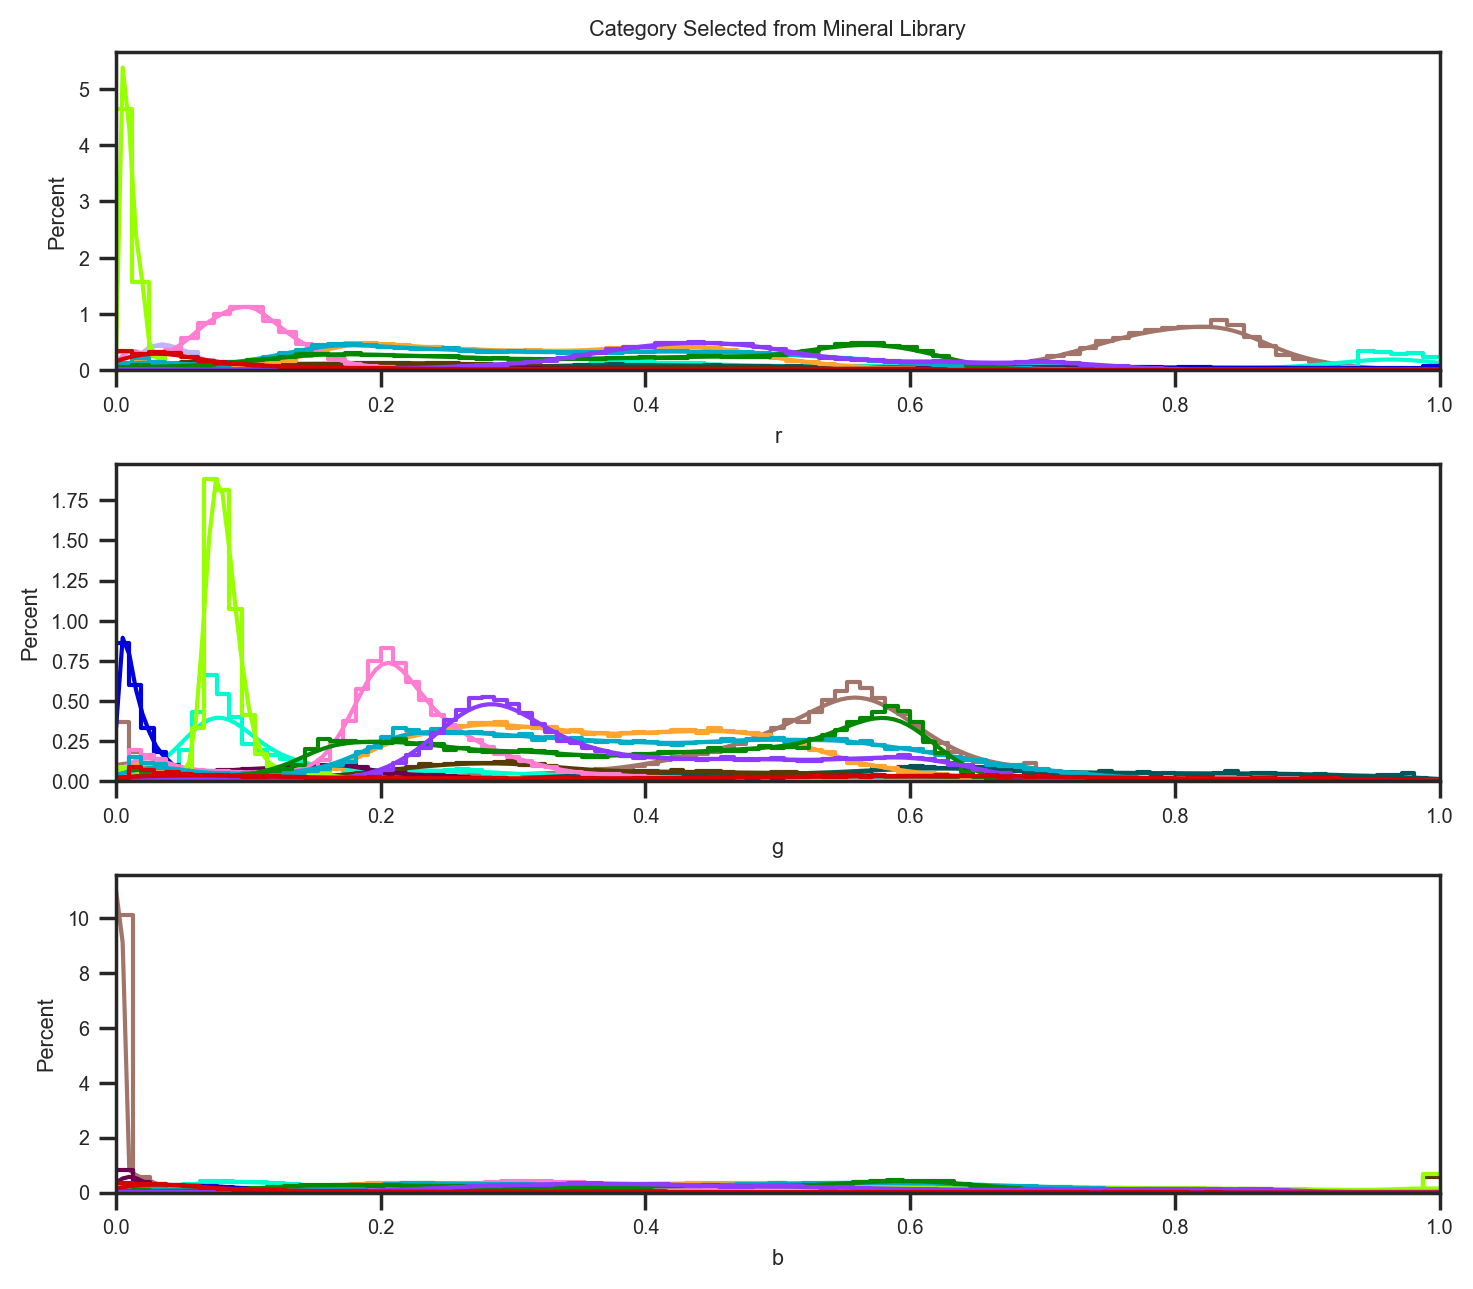

In [116]:
global width, height    
width= 1450
height= 950

root = Tk()
root.geometry(f"{width}x{height}") 
root.title("SC Robotics Mineral Prediction App") 
root.update()
width= root.winfo_width()
height= root.winfo_height()

counter = 0
fltr = [0,100]
blur = 0
x = IntVar
y = IntVar
sample=pd.DataFrame()
pixel_x = []
pixel_y = []
df_current = pd.DataFrame(columns=['r', 'g', 'b', 'short', 'med', 'lon','L', 'A', 'B',
                        'hue', 'saturation', 'value','Mineral'])

left_panel =  Frame(root, width=width/2, height=height)
left_panel.grid(row=0, column=0,sticky=E+W+N+S)

right_panel =  Frame(root, width=width/2, height=height, bg = 'white')
right_panel.grid(row=0, column=1,sticky=E+W+N+S)

class_frame = Frame(right_panel,width=width/2, height=height*2/3, bg = 'white')
class_frame.grid(row=0, column=0,sticky=E+W+N+S)

lib_frame = Frame(right_panel, width=width/2, height=height*1/3, bg = 'white')
lib_frame.grid(row=1, column=0,sticky=E+W+N+S)
    
im_frame = Frame(left_panel, width=width/2, height=height*4/5, bg='black')
im_frame.grid(row=0, column=0,sticky=E+W+N+S)

tool_frame = Frame(left_panel, width=width/2, height=height*1/10)
tool_frame.grid(row=1, column=0,sticky=E+W)

tags_frame = Frame(left_panel, width=width/2, height=height*1/10)
tags_frame.grid(row=2, column=0,sticky=E+W)

file_path = Button(tool_frame, text="Select Image Folder",command= lambda: select_file())
file_path.grid(row=0, column=0, padx=5, pady=1,columnspan = 2)

lib_path = Button(tool_frame, text="Select Training Data",command= lambda: select_lib())
lib_path.grid(row=1, column=0, padx=5, pady=1,columnspan = 2)

select_pixels_button = Button(tool_frame, text = "Exclude Pixel Hue",relief='raised', command = select_pixels)
select_pixels_button.grid(row=0, column=2, padx=5, pady=5)

fltr_slider = CTkRangeSlider(tool_frame,command = change_filter, from_=0,to =100, orientation=HORIZONTAL,
                fg_color='gray',button_color = 'white', progress_color = 'white')
fltr_slider.grid(row=2, column=2,padx=5, pady=5)
fltr_values=Label(tool_frame, text = f"Saturation Filter:{min(fltr): .2f} - {max(fltr): .2f}")
fltr_values.grid(row=1, column=2)

blur_slider = Scale(tool_frame, from_=0,to=10, orient=HORIZONTAL,
                fg='gray',bg = 'white',resolution=1)
blur_slider.grid(row=4, column=2,padx=5, pady=1)
blur_slider.set(blur)
blur_slider.bind("<ButtonRelease-1>",lambda e: change_blur())

undo =  Button(tool_frame, text="Undo", command= lambda: undo_img())
undo.grid(row=0, column=3, padx=5, pady=5)

nxt =  Button(tool_frame, text="Next", command= lambda: next_img())
nxt.grid(row=1, column=3, padx=5, pady=5)

execute = Button(tool_frame, text="Predict", command= lambda: go())
execute.grid(row=0, column=4, padx=5, pady=5)

save_button = Button(tool_frame, text="Save Prediction", command=save)
save_button.grid(row=1, column=4, padx=5, pady=5)

# kick off the GUI

root.mainloop()